In [1]:
import sys
sys.path.append('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Scripts')
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import path
from DataVis import createInputFigure
from NNUtils import *
from NNCreationAux import *
from SSVEPDataset import SSVEPDataset
from SSVEPDataloader import *
from classes import DenseBlock

from sklearn import preprocessing
import os
import time
import copy

In [2]:
def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], sep = ' ', header = None, dtype = float).values)

def dataVisualization(X):
    fig = plt.figure(figsize = (15, 15))
    fig.tight_layout()
    ax = fig.add_subplot()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.imshow(X, cmap = 'gray')
    
    return fig, ax

In [3]:
dataType = '256'
data = pd.read_csv('SSVEPDataset_'+dataType+'.csv')
dataset = SSVEPDataset(data, int(dataType))

batchSize = 128
dataloaders, datasetsSizes = SSVEPDataloaders(dataset, batchSize)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        n1 = 5
        s = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = (1, 2*n1 + 1), padding = (0, n1), stride = (1, s)),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace = True)
        )
        
        self.pool    = nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2), return_indices = True)
        self.unpool  = nn.MaxUnpool2d(kernel_size = (1, 2), stride = (1, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 1, kernel_size = (1, 2*n1 + 1), padding = (0, n1), stride = (1, s), output_padding = (0, s - 1))
        )
        
    
    def forward(self, x):
        x = self.encoder(x)
        x, _2 = self.pool(x)
        x = self.unpool(x, _2)
        x = self.decoder(x)
        
        return x
    
    def encode(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
            x, _ = self.pool(x)
            
        return x

model = Autoencoder()

In [101]:
from torchsummary import summary

In [102]:
summary(model.cuda(), (1, 16, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 16, 256]              36
       BatchNorm2d-2           [-1, 3, 16, 256]               6
              ReLU-3           [-1, 3, 16, 256]               0
         MaxPool2d-4  [[-1, 3, 16, 128], [-1, 3, 16, 128]]               0
       MaxUnpool2d-5           [-1, 3, 16, 256]               0
   ConvTranspose2d-6           [-1, 1, 16, 256]              34
Total params: 76
Trainable params: 76
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 287.59
Params size (MB): 0.00
Estimated Total Size (MB): 287.61
----------------------------------------------------------------


In [103]:
losses = {}

In [10]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
model = model.to(device)
model, _, trainLoss, testLoss = train_autoencoder(model, dataloaders, datasetsSizes, criterion, optimizer, scheduler = None, num_epochs = 100)

--
Epoch 1/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0152
--
Epoch 2/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0152
--
Epoch 3/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0152
--
Epoch 4/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0152
--
Epoch 5/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0151
--
Epoch 6/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0151
--
Epoch 7/100
-----
Stage: train
Loss: 0.0151
Stage: val
Loss: 0.0151
--
Epoch 8/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0151
--
Epoch 9/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0151
--
Epoch 10/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0151
--
Epoch 11/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0151
--
Epoch 12/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0151
--
Epoch 13/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0150
--
Epoch 14/100
-----
Stage: train
Loss: 0.0150
Stage: val
Loss: 0.0150
-

In [105]:
losses['16x128_train'] = trainLoss
losses['16x128_test']  = testLoss

In [18]:
exemplo = next(iter(dataloaders['train']))[0][0].unsqueeze(0)

In [19]:
model = model.to('cpu')
output = model(exemplo).detach()

In [16]:
def dataVisualization(X1, X2):
    fig, axs = plt.subplots(nrows = 2, ncols = 1)
    
    fig.set_size_inches(12, 5)
    fig.subplots_adjust(hspace = 0)
    
    for ax in axs:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    axs[0].imshow(X1, cmap = 'gray'); axs[0].set_title("Original")
    axs[1].imshow(X2, cmap = 'gray'); axs[1].set_title("Autoencoder's Output")
    
    return fig, axs

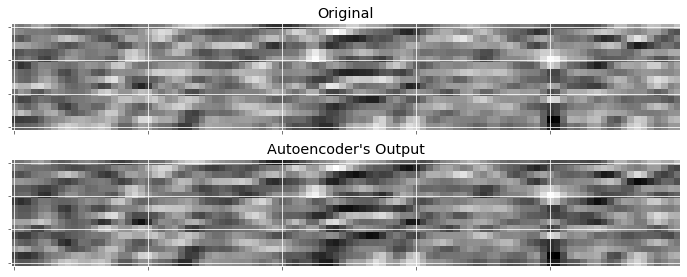

In [20]:
fig, axs = dataVisualization(exemplo.squeeze()[:, :100], output.squeeze()[:, :100])
# fig.savefig("16x64_comparison.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


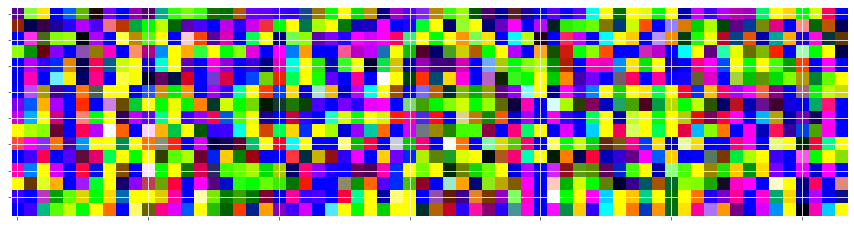

In [21]:
image = model.encode(exemplo).detach()[0]
image = (image.transpose(0, 2).transpose(0, 1).numpy())
fig = plt.figure(figsize = (15, 15))
fig.tight_layout()
ax = fig.add_subplot()
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.imshow(image)
# fig.savefig("16x64_encoded.png")

In [12]:
class HybridModel(nn.Module):
    def __init__(self, encoder):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.classifier = model_selection('resnet18', 5)
        
    def forward(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
        
        x = self.classifier(x)
        
        return x

In [22]:
hybrid = HybridModel(model.encoder)
hybrid = hybrid.to(device)
optimizer = optim.SGD(hybrid.parameters(), lr = 0.001, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
criterion = nn.CrossEntropyLoss()
hybrid, _, _ = kfold_train(hybrid, dataset, criterion, optimizer, num_epochs = 30, num_folds = 5)

Fold 0
--
Epoch 1/30
-----
Stage: train
Loss: 1.7397 - Accuracy: 0.2180
Stage: val
Loss: 1.9310 - Accuracy: 0.1996
--
Epoch 2/30
-----
Stage: train
Loss: 1.6589 - Accuracy: 0.2278
Stage: val
Loss: 2.1425 - Accuracy: 0.2455
--
Epoch 3/30
-----
Stage: train
Loss: 1.6466 - Accuracy: 0.2345
Stage: val
Loss: 1.7773 - Accuracy: 0.2175
--
Epoch 4/30
-----
Stage: train
Loss: 1.6320 - Accuracy: 0.2365
Stage: val
Loss: 1.7032 - Accuracy: 0.2373
--
Epoch 5/30
-----
Stage: train
Loss: 1.6257 - Accuracy: 0.2417
Stage: val
Loss: 1.7278 - Accuracy: 0.2542
--
Epoch 6/30
-----
Stage: train
Loss: 1.6165 - Accuracy: 0.2444
Stage: val
Loss: 1.6694 - Accuracy: 0.2657
--
Epoch 7/30
-----
Stage: train
Loss: 1.5968 - Accuracy: 0.2567
Stage: val
Loss: 1.5739 - Accuracy: 0.2804
--
Epoch 8/30
-----
Stage: train
Loss: 1.5467 - Accuracy: 0.2854
Stage: val
Loss: 1.7058 - Accuracy: 0.2832
--
Epoch 9/30
-----
Stage: train
Loss: 1.5444 - Accuracy: 0.3045
Stage: val
Loss: 1.4853 - Accuracy: 0.3341
--
Epoch 10/30
-----


***

In [6]:
def train_autoencoder(model, dataloaders, dataset_size, criterion, optimizer, scheduler = None, num_epochs = 10):
    since = time.time()
    
    best_model_wgts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    trainLoss = []
    testLoss  = []
    
    for epoch in range(num_epochs):
        print('-'*2)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*5)
        
        for phase in ['train', 'val']:
            print('Stage: {}'.format(phase))
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            cumulative_loss = 0.0
            cumulative_hits  = 0
            
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                cumulative_loss += loss.item()*inputs.size(0)
                del(inputs); del(_)
                
            if phase == 'train' and scheduler != None:
                scheduler.step()
            
            epoch_loss = cumulative_loss / dataset_size[phase]
            
            if phase == 'train':
                trainLoss.append(epoch_loss)
            else:
                testLoss.append(epoch_loss)
                
            print('Loss: {:.4f}'.format(epoch_loss))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wgts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print('Best validation loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wgts)
    return model, time_elapsed, trainLoss, testLoss 

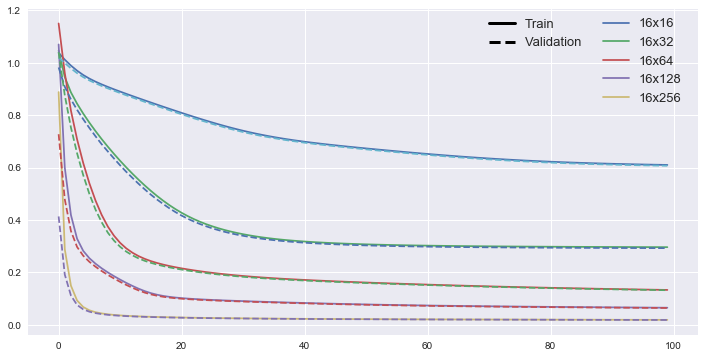

In [98]:
from matplotlib.lines import Line2D
plt.style.use('seaborn')

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(12, 6)

sizes = ['16', '32', '64', '128', '256']
labels = []
for s in sizes:
    labels.append('16x'+s)
    ax.plot(range(100), losses['16x'+s+'_train'])

lines = ax.get_lines()
    
for s in sizes:
    ax.plot(range(100), losses['16x'+s+'_test'], linestyle = '--')
    
    
trainline = Line2D([0], [0], color='k', linewidth=3, linestyle='-')
valline   = Line2D([0], [0], color='k', linewidth=3, linestyle='--')


legend1 = plt.legend(lines, labels, loc = (0.85, 0.69), fontsize = 13)
legend2 = plt.legend([trainline, valline], ['Train', 'Validation'], loc = (0.68, 0.86), fontsize = 13)

plt.gca().add_artist(legend1)
fig.savefig("trainingautoencoder.png")